# Programming for Data Science and Artificial Intelligence

## 0. Linear Regression Extension

You have learned all the detail of Linear Regression. Its core idea is presented in the lecture.

To enhance the `Gradient` function, there are two extensions that improve the optimization process in terms of quality of life (your life).

1. Early Stopping
2. Momentum

In [96]:
#  Code from the class
import numpy as np
from sklearn.model_selection import KFold


def mean_squared_error(ytrue, ypred):
    return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]

class LinearRegression(object):
    
    kfold = KFold(n_splits=5)
            
    def __init__(self, alpha=0.001, num_epochs=5, batch_size=50, method='batch',
                 cv=kfold):
        self.alpha      = alpha
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.cv         = cv
    
    def fit(self, X_train, y_train):
        
        #using training......
        
        #please change it to cross-validation.....
        
        #create a list of kfold scores
        self.kfold = list()

        #Kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
            
            #create self.theta here
            self.theta = np.zeros(X_cross_train.shape[1])
            
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            
            #one epoch will exhaust the WHOLE training set
            for epoch in range(self.num_epochs):
            
                #with replacement or no replacement
                #with replacement means just randomize
                #with no replacement means 0:50, 51:100, 101:150, ......300:323
                #shuffle your index
                #===> please shuffle your index
                perm = np.random.permutation(X_cross_train.shape[0])
                        
                X_cross_train = X_cross_train[perm]
                y_cross_train = y_cross_train[perm]
                
                if   self.method == 'sto':
                    for batch_idx in range(X_cross_train.shape[0]):
                        X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                        y_method_train = y_cross_train[batch_idx]                    
                        self._train(X_method_train, y_method_train)
                elif self.method == 'mini':
                    for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                        #batch_idx = 0, 50, 100, 150
                        X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                        y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                        self._train(X_method_train, y_method_train)
                else:
                    X_method_train = X_cross_train
                    y_method_train = y_cross_train
                    self._train(X_method_train, y_method_train)
                    
            yhat_val = self.predict(X_cross_val)
            self.kfold.append(mean_squared_error(y_cross_val, yhat_val))
            print(f"Fold {fold}: {mean_squared_error(y_cross_val, yhat_val)}")
                    
    def _train(self, X, y):
        yhat = self.predict(X)
        grad = X.T @(yhat - y)
        self.theta = self.theta - self.alpha * grad
    
    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercep
                               #w1....wn are the weights / coefficients / theta
        
    def _bias(self):
        return self.theta[0]

In [2]:
from sklearn.datasets import load_diabetes
X,y = load_diabetes(return_X_y=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 9999)

#Standardize
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = np.insert(X_train,0,1,axis=1)
X_test = np.insert(X_test,0,1,axis=1)

## 1. Early Stopping

`num_epochs` is the parameter that specify how many iteration your model will perform the optimization.

The question to ask is "How many `num_epochs` is enough?".

The answer is when your model is optimized.

Optimized? What is optimized?

Ah.. young padawan, remember this figure?

<img width="400" src = "figures/gradient.png">

We say the model is trained/optimized/learned when *it* reachs the minima, preferably, global minima.

Our goal of optimization in this Gradient context is to minimize the loss/error.

$$ \min_{\theta} || \hat{y} - y ||^2_2 $$

$\theta$ is vector of weights to optimize.

$\hat{y}$ is actually a result of $ \mathbf{X}\theta $.

$y$ is a vector of ground-truth/label.

$|| . ||^2_2$ is the loss/error function. 

Now, you remember your objective. It is to minimize the $|| . ||^2_2$ by adjusting the $ \theta $

Then, the model is done training when you finally get the $ \theta $ that yeild the best result (lowest error / minima).

### How do you know you are there at the minima?

Well, one way is to tracking your loss over the training session. 

![loss](https://miro.medium.com/max/411/1*UHmMMH3OhrBvgw18jKiy6Q.png)

You see, when you plot the loss/error (in the figure is cost) over the epochs, it should be desending and finally plateau.

When it is plateau, in other words, adjusting $\theta$ no longer improve the prediction. You are at the minima. (Gradient is 0 at minima).

According to the plot of lost/error, when do we reach the minima? 3000?, 2000?, 1000?

In this case, do you need to set `num_epochs` to 3000?

In the next dataset you will work on, what `num_epochs` you need to set?

Ah.. You will never know until you train the model with that new dataset, at least, one time.

Can we do better?

Yes, we can. Introducing!!!!!!!!! `Early Stopping`!!!!!!!!!

### Early Stopping

The idea of `early stoping` is, as the name suggest, break the training before it reachs the `num_epochs`.

The key is **no longer improve**. **Improve!!**. What is improve?

Improve is the loss of iteration/epoch *i* is lower than the *i-1*.

How much is the $\text{loss}_i - \text{loss}_{i-1}$ so that we say it is improving? This is up to you. 

Now code!!!


In [ ]:
### pesudo code for people who has no idea

# for _ in range(epochs)
#   train(x_train, y_train)
#   loss = error(predict(x_train) - y_train)
#   if prev_loss - loss > theshold
#      ok, there is an improment
#      prev_loss = loss
#   else
#      done training. break

In [25]:
#earlystopping
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def mean_squared_error(ytrue, ypred):
        return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]

class LinearRegression_early_stopping(object):
    
    kfold = KFold(n_splits=5)
            
    def __init__(self, alpha=0.001, num_epochs=5, batch_size=50, method='batch', tol = 1e-5,
                 cv=kfold):
        self.alpha      = alpha
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.cv         = cv
        self.tol        = tol
    
    def fit(self, X_train, y_train):
        
        #using training......
        
        #please change it to cross-validation.....
        
        #create a list of kfold scores
        self.kfold = list()
        self.loss_old = np.infty
        #Kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
            
            #create self.theta here
            self.theta = np.zeros(X_cross_train.shape[1])
            self.J_per_iter = list()
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            #one epoch will exhaust the WHOLE training set

            for epoch in range(self.num_epochs):
            
                #with replacement or no replacement
                #with replacement means just randomize
                #with no replacement means 0:50, 51:100, 101:150, ......300:323
                #shuffle your index
                #===> please shuffle your index
                perm = np.random.permutation(X_cross_train.shape[0])
                        
                X_cross_train = X_cross_train[perm]
                y_cross_train = y_cross_train[perm]
                
                if   self.method == 'sto':
                    for batch_idx in range(X_cross_train.shape[0]):
                        X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                        y_method_train = y_cross_train[batch_idx]                    
                        self._train(X_method_train, y_method_train,epoch)
                elif self.method == 'mini':
                    for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                        #batch_idx = 0, 50, 100, 150
                        X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                        y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                        self._train(X_method_train, y_method_train)
                else:
                    X_method_train = X_cross_train
                    y_method_train = y_cross_train
                    self._train(X_method_train, y_method_train)
                    
                    
                yhat_val = self.predict(X_cross_val)

                #Early stopping
                loss_new = mean_squared_error(y_cross_val, yhat_val)
                # print(loss_new)
                self.J_per_iter.append(loss_new)
                if np.allclose(loss_new, self.loss_old):
                # if self.delta_loss(loss_new, self.loss_old, self.tol):  
                    print('iteration stop at',epoch)
                    break
                self.loss_old = loss_new

            self.kfold.append(mean_squared_error(y_cross_val, yhat_val))
            # print(f"Fold {fold}: {mean_squared_error(y_cross_val, yhat_val)}")
            
        self.cost_plot(self.J_per_iter)
        # print(len(self.J_per_iter))

    def delta_loss(self, loss_new, loss_old , tol):
        return np.abs(loss_new - loss_old ) < tol

    def cost_plot(self, arr_J):
        itreation = np.arange(0, len(self.J_per_iter), 1)
        plt.plot(itreation, arr_J)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()
                  
    def _train(self, X, y):
        yhat = self.predict(X)
        grad = X.T @ (yhat - y) #gradient
        self.theta = self.theta - self.alpha * grad
    
    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercep
                               #w1....wn are the weights / coefficients / theta
        
    def _bias(self):
        return self.theta[0]

iteration stop at 529
iteration stop at 36
iteration stop at 405


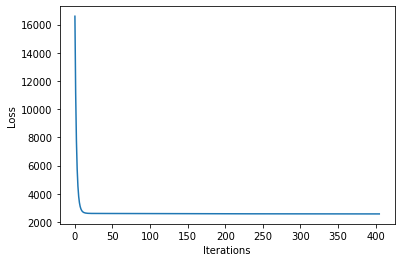

In [28]:
early = LinearRegression_early_stopping(num_epochs = 1000)
early.fit(X_train,y_train)

## 2. Momentum

`alpha` or `learning_rate` is the parameter how big of the step you will take on each Gradient optimization step.

![overshoot](https://miro.medium.com/max/700/1*hGhRddOUV8h0pdQek8T35A.png)

How much is `alpha` you should set?

Not big such that it causes the *over shooting*.

And certainly, not too small such that it causes you extra epochs to reach the minima.

You want **just right** `alpha`.

How do you know what is the right `alpha`?

You guess, right?

This time, 0.1. Observe the loss. If it is overshooting, stop and reduce the `alpha`. If the loss reduce slightly, maybe stop and increase the `alpha`.

Finally, if you spend time adjusting the `alpha`, you will eventually find the **just right** `alpha`.

Can we do better? Can we reduce the number of epochs without searching for the **just right** `alpha`.

Yes, we can!!! Introducing!!!!!!!! MOMENTUM~~!!!!!!!!!

### Momentum

Here is the updating equation.

$$ \theta^{i+1} = \theta^{i} - \alpha \times \text{gradient}^i $$

$i$ is the iteration/epoch number.

$\theta^{i+1}$ is the updated weights and will be used for the next iteration.

$\theta^{i}$ is the current weights of iteration $i$.

$\alpha$ is the learning rate.

$\text{gradient}^i$ is the step suggesting by the deviation of loss function from iteration $i$.

$\alpha \times \text{gradient}^i$ can be called *step*. When consider $i$, we call the $step^i$ how big of the step you take in iteration $i$.

We know, in the early iteration, the step will be very big. Given the `alpha` is not too big, the step will decrase over time.

Let's say our step size was big in the previous iteration (i-1), maybe, instead of taking $step^i$, we can take bigger step than $step^i$.

Yes, and here is the equation.

$$ \theta^{i+1} = \theta^{i} - step^i + \text{momentum} \times step^{i-1} $$

Then, *momentum* here is how much do you want to include the information of previous step. The range of *momentum* is $[0.0 - 1.0]$. When *momentum* is 0 then you do not use previous step (basically, normal optimization). When it is 1 then you fully use the information from previous step. 

Now, code !!!!

In [ ]:
### pesudo code for people who has no idea

# step = alpha * grad
# theta = theta - step + momentum * prev_step
# prev_step = step

In [20]:
#momemtum
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def mean_squared_error(ytrue, ypred):
    return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]

class LinearRegression_momemtum(object):
    
    kfold = KFold(n_splits=5)
            
    def __init__(self, alpha=0.001, num_epochs=5, batch_size=50, method='batch',momentum=0.5,
                 cv=kfold):
        self.alpha      = alpha
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.cv         = cv
        self.momentum   = momentum
        self.prev_step  = None
    
    def fit(self, X_train, y_train):
        
        #using training......
        
        #please change it to cross-validation.....
        
        #create a list of kfold scores
        self.kfold = list()
        #Kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
            
            #create self.theta here
            self.theta = np.zeros(X_cross_train.shape[1])
            
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            self.J_per_iter = list()
            #one epoch will exhaust the WHOLE training set
            for epoch in range(self.num_epochs):
            
                #with replacement or no replacement
                #with replacement means just randomize
                #with no replacement means 0:50, 51:100, 101:150, ......300:323
                #shuffle your index
                #===> please shuffle your index
                perm = np.random.permutation(X_cross_train.shape[0])
                        
                X_cross_train = X_cross_train[perm]
                y_cross_train = y_cross_train[perm]
                
                if   self.method == 'sto':
                    for batch_idx in range(X_cross_train.shape[0]):
                        X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                        y_method_train = y_cross_train[batch_idx]                    
                        self._train(X_method_train, y_method_train)
                elif self.method == 'mini':
                    for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                        #batch_idx = 0, 50, 100, 150
                        X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                        y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                        self._train(X_method_train, y_method_train)
                else:
                    X_method_train = X_cross_train
                    y_method_train = y_cross_train
                    self._train(X_method_train, y_method_train)

                #Plotting Cost Function
                yhat_train = self.predict(X_method_train)
                loss = mean_squared_error(yhat_train, y_method_train)
                self.J_per_iter.append(loss)

            #test
            yhat_val = self.predict(X_cross_val)
            self.kfold.append(mean_squared_error(y_cross_val, yhat_val))
            print(f"Fold {fold}: {mean_squared_error(y_cross_val, yhat_val)}")
 
        self.cost_plot(self.J_per_iter)

    def cost_plot(self, arr_J):
        itreation = np.arange(0, self.num_epochs, 1)
        plt.plot(itreation, arr_J)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()

    def _train(self, X, y):
        yhat = self.predict(X)
        grad = X.T @ (yhat - y)
        #Momemtum
        step = self.alpha * grad
        if self.prev_step is None:
            self.theta = self.theta - step 
            self.prev_step = step
        else:
            self.theta = self.theta - step + self.momentum * self.prev_step
            self.prev_step = step

    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercep
                               #w1....wn are the weights / coefficients / theta
        
    def _bias(self):
        return self.theta[0]

Fold 0: 2839387.6779988464
Fold 1: 30711742.19280446
Fold 2: 26998857220.016594
Fold 3: 14032914274.901747
Fold 4: 38555782075.85248


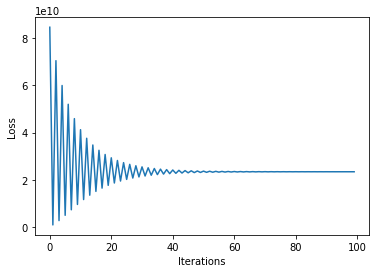

In [26]:
momemtum = LinearRegression_momemtum(num_epochs = 100, momentum=1)
momemtum.fit(X_train,y_train)